# Restaurant Annual Turnover Prediction

### Problem Statement
- **Goal**: Predict Annual Turnover of resturants
- **Metrics**: RMSE (Root mean squred Error) - Lower is better
- **Approach**: Feature engineering + Multiple ML Models + Ensemble method

## 1. Import Libraries

In [17]:
# Data Manipulation
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


# visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-darkgrid')

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost not available. Install with: pip install xgboost")
    XGBOOST_AVAILABLE = False

try:
    from lightgbm import LGBMRegressor
    LIGHTGBM_AVAILABLE = True
except ImportError:
    print("LightGBM not available. Install with: pip install lightgbm")
    LIGHTGBM_AVAILABLE = False


print("All libraries imported successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")

All libraries imported successfully!
XGBoost available: True
LightGBM available: True


## 2. Load and Analyse Data

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# Load datasets
train_df = pd.read_csv('/content/drive/MyDrive/restaurant_annual_turnover/Train_dataset_.csv')
test_df = pd.read_csv('/content/drive/MyDrive/restaurant_annual_turnover/Test_dataset_.csv')

print("="*70)
print("DATASET OVERVIEW")
print("="*70)
print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")
print(f"\nTarget variable statistics:")
print(train_df['Annual Turnover'].describe())

DATASET OVERVIEW
Training set shape: (3493, 34)
Test set shape: (500, 33)

Target variable statistics:
count    3.493000e+03
mean     3.072571e+07
std      2.165125e+07
min      3.500000e+06
25%      1.800000e+07
50%      3.000000e+07
75%      3.700000e+07
max      4.000000e+08
Name: Annual Turnover, dtype: float64


In [20]:
# Check for missing values
print("\n" + "="*70)
print("MISSING VALUES IN TRAINING DATA")
print("="*70)
missing = train_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print(missing)


MISSING VALUES IN TRAINING DATA
Live Sports Rating               3288
Value Deals Rating               2707
Comedy Gigs Rating               2483
Live Music Rating                 765
Overall Restaurant Rating         212
Facebook Popularity Quotient       99
Instagram Popularity Quotient      56
Resturant Tier                     49
Ambience                           25
dtype: int64


In [21]:
# Display first few rows
print("\n" + "="*70)
print("FIRST 3 ROWS")
print("="*70)
display(train_df.head(3))


FIRST 3 ROWS


,Registration Number,Annual Turnover,Cuisine,City,Restaurant Location,Opening Day of Restaurant,Facebook Popularity Quotient,Endorsed By,Instagram Popularity Quotient,Fire Audit,...,Overall Restaurant Rating,Live Music Rating,Comedy Gigs Rating,Value Deals Rating,Live Sports Rating,Ambience,Lively,Service,Comfortablility,Privacy
0,60001,42000000,"indian,irish",Bangalore,Near Business Hub,14-02-2009,84.3,Not Specific,95.8,1,...,10.0,4.0,NaN,NaN,NaN,8.0,8,6,6,6
1,60002,50000000,"indian,irish",Indore,Near Party Hub,29-09-2008,85.4,Tier A Celebrity,85.0,1,...,9.0,NaN,4.0,NaN,NaN,5.0,7,7,3,8
2,60003,32500000,"tibetan,italian",Chennai,Near Business Hub,30-07-2011,85.0,Tier A Celebrity,68.2,1,...,8.0,3.0,NaN,NaN,NaN,7.0,10,5,2,8


## 3. Feature Engineering
Creating features from existing data to improve model performance.

In [22]:
def engineer_features(df, is_train=True):
    """
    Comprehensive feature engineering with column existence checks
    """
    df = df.copy()

    # DATE FEATURES
    if 'Opening Day of Restaurant' in df.columns:
        df['Opening Day of Restaurant'] = pd.to_datetime(
            df['Opening Day of Restaurant'],
            format='%d-%m-%Y',
            errors='coerce'
        )

        current_date = datetime(2025, 12, 14)
        df['Restaurant_Age_Days'] = (current_date - df['Opening Day of Restaurant']).dt.days
        df['Restaurant_Age_Years'] = df['Restaurant_Age_Days'] / 365.25
        df['Opening_Year'] = df['Opening Day of Restaurant'].dt.year
        df['Opening_Month'] = df['Opening Day of Restaurant'].dt.month
        df['Opening_Quarter'] = df['Opening Day of Restaurant'].dt.quarter
        df['Opening_DayOfWeek'] = df['Opening Day of Restaurant'].dt.dayofweek
        df['Opened_in_Summer'] = df['Opening_Month'].isin([6, 7, 8]).astype(int)
        df['Opened_in_Winter'] = df['Opening_Month'].isin([12, 1, 2]).astype(int)
    else:
        df['Restaurant_Age_Days'] = 0
        df['Restaurant_Age_Years'] = 0
        df['Opening_Year'] = 0
        df['Opening_Month'] = 0
        df['Opening_Quarter'] = 0
        df['Opening_DayOfWeek'] = 0
        df['Opened_in_Summer'] = 0
        df['Opened_in_Winter'] = 0

    # CUISINE FEATURES
    if 'Cuisine' in df.columns:
        df['Cuisine'] = df['Cuisine'].astype(str)
        df['Cuisine_Count'] = df['Cuisine'].str.count(',') + 1
        df['Cuisine1'] = df['Cuisine'].str.split(',').str[0].str.strip()
        df['Cuisine2'] = df['Cuisine'].str.split(',').str[1].str.strip()
        df['Has_Multiple_Cuisines'] = (df['Cuisine_Count'] > 1).astype(int)

        cuisine_list = df['Cuisine'].str.lower().str.split(',').explode().str.strip()
        popular_cuisines = cuisine_list.value_counts().head(5).index.tolist()

        for cuisine in popular_cuisines:
            col_name = f'Has_{cuisine.title().replace(" ", "_")}'
            df[col_name] = df['Cuisine'].str.lower().str.contains(cuisine, na=False).astype(int)
    else:
        df['Cuisine_Count'] = 0
        df['Cuisine1'] = ''
        df['Cuisine2'] = ''
        df['Has_Multiple_Cuisines'] = 0

    # LOCATION FEATURES
    if 'City' in df.columns:
        df['City'] = df['City'].astype(str)
        df['City'] = df['City'].replace({
            'Banglore': 'Bangalore',
            'bangalore': 'Bangalore',
            '-1': 'Unknown'
        })
        df['City'] = df['City'].str.strip().str.title()

    if 'Restaurant Location' in df.columns:
        df['Restaurant Location'] = df['Restaurant Location'].astype(str)
        df['Is_Business_Hub'] = (df['Restaurant Location'] == 'Near Business Hub').astype(int)
        df['Is_Party_Hub'] = (df['Restaurant Location'] == 'Near Party Hub').astype(int)
    else:
        df['Is_Business_Hub'] = 0
        df['Is_Party_Hub'] = 0

    # SOCIAL MEDIA FEATURES
    if 'Facebook Popularity Quotient' in df.columns and 'Instagram Popularity Quotient' in df.columns:
        df['Social_Media_Avg'] = df[['Facebook Popularity Quotient',
                                       'Instagram Popularity Quotient']].mean(axis=1)
        df['Social_Media_Max'] = df[['Facebook Popularity Quotient',
                                       'Instagram Popularity Quotient']].max(axis=1)
        df['Social_Media_Min'] = df[['Facebook Popularity Quotient',
                                       'Instagram Popularity Quotient']].min(axis=1)
        df['Social_Media_Range'] = df['Social_Media_Max'] - df['Social_Media_Min']
        df['Instagram_vs_Facebook'] = df['Instagram Popularity Quotient'] - df['Facebook Popularity Quotient']
        df['High_Social_Media'] = (df['Social_Media_Avg'] > 85).astype(int)
    else:
        df['Social_Media_Avg'] = 0
        df['Social_Media_Max'] = 0
        df['Social_Media_Min'] = 0
        df['Social_Media_Range'] = 0
        df['Instagram_vs_Facebook'] = 0
        df['High_Social_Media'] = 0

    # ENDORSEMENT FEATURES
    endorsement_col = None
    if 'Endorsed By' in df.columns:
        endorsement_col = 'Endorsed By'
    elif 'Endoresed By' in df.columns:
        endorsement_col = 'Endoresed By'
        df = df.rename(columns={'Endoresed By': 'Endorsed By'})

    if endorsement_col or 'Endorsed By' in df.columns:
        df['Has_Celebrity_Endorsement'] = (df['Endorsed By'].str.contains('Celebrity', na=False)).astype(int)
        df['No_Endorsement'] = (df['Endorsed By'] == 'Not Specific').astype(int)
    else:
        df['Has_Celebrity_Endorsement'] = 0
        df['No_Endorsement'] = 0

    # RATING FEATURES
    rating_cols = [col for col in ['Overall Restaurant Rating', 'Live Music Rating',
                   'Comedy Gigs Rating', 'Value Deals Rating', 'Live Sports Rating']
                   if col in df.columns]

    entertainment_ratings = [col for col in ['Live Music Rating', 'Comedy Gigs Rating',
                            'Value Deals Rating', 'Live Sports Rating']
                            if col in df.columns]

    for col in entertainment_ratings:
        df[col] = df[col].fillna(0)

    if rating_cols:
        df['Avg_Rating'] = df[rating_cols].mean(axis=1)
        df['Max_Rating'] = df[rating_cols].max(axis=1)
        df['Min_Rating'] = df[rating_cols].min(axis=1)
        df['Rating_Range'] = df['Max_Rating'] - df['Min_Rating']
        df['Rating_Count'] = df[rating_cols].notna().sum(axis=1)
        df['Has_Entertainment'] = (df[entertainment_ratings].sum(axis=1) > 0).astype(int) if entertainment_ratings else 0
        df['Entertainment_Score'] = df[entertainment_ratings].sum(axis=1) if entertainment_ratings else 0
    else:
        df['Avg_Rating'] = 0
        df['Max_Rating'] = 0
        df['Min_Rating'] = 0
        df['Rating_Range'] = 0
        df['Rating_Count'] = 0
        df['Has_Entertainment'] = 0
        df['Entertainment_Score'] = 0

    if 'Overall Restaurant Rating' in df.columns:
        df['High_Overall_Rating'] = (df['Overall Restaurant Rating'] >= 8).astype(int)
    else:
        df['High_Overall_Rating'] = 0

    # SERVICE & AMBIENCE FEATURES
    service_cols = [col for col in ['Ambience', 'Lively', 'Service', 'Comfortablility', 'Privacy']
                    if col in df.columns]

    if service_cols:
        df['Service_Score_Avg'] = df[service_cols].mean(axis=1)
        df['Service_Score_Sum'] = df[service_cols].sum(axis=1)
        df['Service_Score_Max'] = df[service_cols].max(axis=1)
        df['High_Service'] = (df['Service_Score_Avg'] > 6).astype(int)
    else:
        df['Service_Score_Avg'] = 0
        df['Service_Score_Sum'] = 0
        df['Service_Score_Max'] = 0
        df['High_Service'] = 0

    # FACILITY FEATURES
    facility_cols = [col for col in ['Fire Audit', 'Liquor License Obtained',
                    'Situated in a Multi Complex', 'Dedicated Parking',
                    'Open Sitting Available'] if col in df.columns]

    if facility_cols:
        df['Total_Facilities'] = df[facility_cols].sum(axis=1)
        df['Has_All_Facilities'] = (df['Total_Facilities'] == len(facility_cols)).astype(int)
    else:
        df['Total_Facilities'] = 0
        df['Has_All_Facilities'] = 0

    if 'Liquor License Obtained' in df.columns and 'Dedicated Parking' in df.columns:
        df['Has_Liquor_and_Parking'] = ((df['Liquor License Obtained'] == 1) &
                                        (df['Dedicated Parking'] == 1)).astype(int)
    else:
        df['Has_Liquor_and_Parking'] = 0

    # QUALITY METRICS
    quality_cols = [col for col in ['Hygiene Rating', 'Food Rating', 'Value for Money']
                    if col in df.columns]

    if len(quality_cols) == 3:
        df['Quality_Score'] = df[quality_cols].mean(axis=1)
    else:
        df['Quality_Score'] = 0

    if 'Staff Responsivness' in df.columns and 'Service' in df.columns:
        df['Service_Quality'] = (df['Staff Responsivness'] + df['Service']) / 2
    else:
        df['Service_Quality'] = 0

    if 'Hygiene Rating' in df.columns and 'Food Rating' in df.columns:
        df['High_Quality'] = ((df['Hygiene Rating'] >= 8) &
                             (df['Food Rating'] >= 8)).astype(int)
    else:
        df['High_Quality'] = 0

    # INTERACTION FEATURES
    df['Age_x_Rating'] = df.get('Restaurant_Age_Years', 0) * df.get('Overall Restaurant Rating', 0)
    df['Social_x_Rating'] = df.get('Social_Media_Avg', 0) * df.get('Overall Restaurant Rating', 0)
    df['Quality_x_Service'] = df.get('Quality_Score', 0) * df.get('Service_Score_Avg', 0)

    if 'Restaurant Zomato Rating' in df.columns:
        df['Zomato_x_Age'] = df['Restaurant Zomato Rating'] * df.get('Restaurant_Age_Years', 0)
    else:
        df['Zomato_x_Age'] = 0

    # TIER FEATURES
    if 'Resturant Tier' in df.columns:
        df['Resturant Tier'] = df['Resturant Tier'].astype(str)
        df['Is_Tier_1'] = (df['Resturant Tier'].str.contains('1', na=False)).astype(int)
        df['Is_Tier_2'] = (df['Resturant Tier'].str.contains('2', na=False)).astype(int)
    else:
        df['Is_Tier_1'] = 0
        df['Is_Tier_2'] = 0

    if 'Restaurant City Tier' in df.columns:
        df['Is_Metro_City'] = (df['Restaurant City Tier'] == 'Tier 1').astype(int)
    else:
        df['Is_Metro_City'] = 0

    print(f"Feature engineering complete. New shape: {df.shape}")
    return df

## 4. Data Preprocessing

Handling missing values and encoding categorical variables.

In [23]:
def preprocess_data(train, test):
    """
    Preprocess training and test data
    """
    # Separate target and features
    y_train = train['Annual Turnover'].values
    X_train = train.drop(['Annual Turnover', 'Registration Number',
                          'Opening Day of Restaurant', 'Cuisine'], axis=1, errors='ignore')
    X_test = test.drop(['Registration Number', 'Opening Day of Restaurant',
                        'Cuisine'], axis=1, errors='ignore')
    test_ids = test['Registration Number'].values

    # Align columns - use only common features
    common_cols = [col for col in X_train.columns if col in X_test.columns]
    X_train = X_train[common_cols]
    X_test = X_test[common_cols]
    print(f"Using {len(common_cols)} common features")

    # Identify column types
    numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

    print(f"Numeric features: {len(numeric_cols)}")
    print(f"Categorical features: {len(categorical_cols)}")

    # Handle missing values in numeric columns
    numeric_imputer = SimpleImputer(strategy='median')
    X_train[numeric_cols] = numeric_imputer.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = numeric_imputer.transform(X_test[numeric_cols])

    # Handle categorical columns
    label_encoders = {}
    for col in categorical_cols:
        X_train[col] = X_train[col].fillna('Unknown')
        X_test[col] = X_test[col].fillna('Unknown')

        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col].astype(str))

        X_test[col] = X_test[col].apply(
            lambda x: le.transform([str(x)])[0] if str(x) in le.classes_ else -1
        )
        label_encoders[col] = le

    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, test_ids, X_train.columns

In [24]:
# EXECUTE FEATURE ENGINEERING AND PREPROCESSING

# Reload fresh data
print("\n" + "="*70)
print("RELOADING CLEAN DATA")
print("="*70)
train_df = pd.read_csv('/content/drive/MyDrive/restaurant_annual_turnover/Train_dataset_.csv')
test_df = pd.read_csv('/content/drive/MyDrive/restaurant_annual_turnover/Test_dataset_.csv')
print(f"Training set: {train_df.shape}")
print(f"Test set: {test_df.shape}")

# Fix typo
if 'Endoresed By' in test_df.columns:
    test_df = test_df.rename(columns={'Endoresed By': 'Endorsed By'})
    print("Fixed typo in test set")

# Apply feature engineering
print("\n" + "="*70)
print("APPLYING FEATURE ENGINEERING")
print("="*70)
train_df = engineer_features(train_df, is_train=True)
test_df = engineer_features(test_df, is_train=False)

# Apply preprocessing
print("\n" + "="*70)
print("APPLYING PREPROCESSING")
print("="*70)
X_train, X_test, y_train, test_ids, feature_names = preprocess_data(train_df, test_df)

print(f"\nReady for model training!")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")


RELOADING CLEAN DATA
Training set: (3493, 34)
Test set: (500, 33)
Fixed typo in test set

APPLYING FEATURE ENGINEERING
Feature engineering complete. New shape: (3493, 86)
Feature engineering complete. New shape: (500, 85)

APPLYING PREPROCESSING
Using 82 common features
Numeric features: 70
Categorical features: 8

Ready for model training!
X_train shape: (3493, 82)
X_test shape: (500, 82)
y_train shape: (3493,)


## 5. Model Training & Evaluation

Training multiple models and comparing their performance.

In [25]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Train and evaluate a model
    """
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    train_r2 = r2_score(y_train, y_pred_train)
    val_r2 = r2_score(y_val, y_pred_val)
    val_mae = mean_absolute_error(y_val, y_pred_val)

    results = {
        'Model': model_name,
        'Train_RMSE': train_rmse,
        'Val_RMSE': val_rmse,
        'Train_R2': train_r2,
        'Val_R2': val_r2,
        'Val_MAE': val_mae,
        'Overfitting': train_rmse - val_rmse
    }

    return results, model

# Split data for validation
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("\n" + "="*70)
print("MODEL TRAINING & EVALUATION")
print("="*70)

# Define models
models = [
    (Ridge(alpha=1000), 'Ridge Regression'),
    (Lasso(alpha=1000), 'Lasso Regression'),
    (RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=5,
                          random_state=42, n_jobs=-1), 'Random Forest'),
    (GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1,
                              random_state=42), 'Gradient Boosting'),
    (ExtraTreesRegressor(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1),
     'Extra Trees')
]

if XGBOOST_AVAILABLE:
    models.append((
        xgb.XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05,
                        random_state=42, n_jobs=-1),
        'XGBoost'
    ))

if LIGHTGBM_AVAILABLE:
    models.append((
        LGBMRegressor(n_estimators=300, max_depth=6, learning_rate=0.05,
                     random_state=42, n_jobs=-1, verbose=-1),
        'LightGBM'
    ))

# Train and evaluate all models
results_list = []
trained_models = {}

for model, name in models:
    print(f"\nTraining {name}...")
    results, trained_model = evaluate_model(model, X_tr, y_tr, X_val, y_val, name)
    results_list.append(results)
    trained_models[name] = trained_model

    print(f"  Val RMSE: {results['Val_RMSE']:,.0f}")
    print(f"  Val R2: {results['Val_R2']:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values('Val_RMSE')

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)
display(results_df.style.format({
    'Train_RMSE': '{:,.0f}',
    'Val_RMSE': '{:,.0f}',
    'Train_R2': '{:.4f}',
    'Val_R2': '{:.4f}',
    'Val_MAE': '{:,.0f}',
    'Overfitting': '{:,.0f}'
}).background_gradient(subset=['Val_RMSE'], cmap='RdYlGn_r'))

# Select best model
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
best_rmse = results_df.iloc[0]['Val_RMSE']

print(f"\nBest Model: {best_model_name}")
print(f"Validation RMSE: {best_rmse:,.0f}")


MODEL TRAINING & EVALUATION

Training Ridge Regression...
  Val RMSE: 19,583,798
  Val R2: 0.1565

Training Lasso Regression...
  Val RMSE: 19,545,395
  Val R2: 0.1598

Training Random Forest...
  Val RMSE: 19,475,739
  Val R2: 0.1658

Training Gradient Boosting...
  Val RMSE: 19,943,595
  Val R2: 0.1252

Training Extra Trees...
  Val RMSE: 20,264,435
  Val R2: 0.0968

Training XGBoost...
  Val RMSE: 19,226,783
  Val R2: 0.1869

Training LightGBM...
  Val RMSE: 19,722,698
  Val R2: 0.1445

MODEL COMPARISON


,Model,Train_RMSE,Val_RMSE,Train_R2,Val_R2,Val_MAE,Overfitting
5,XGBoost,"5,933,472","19,226,783",0.9254,0.1869,"10,629,388","-13,293,310"
2,Random Forest,"10,365,996","19,475,739",0.7724,0.1658,"10,579,322","-9,109,743"
1,Lasso Regression,"20,033,652","19,545,395",0.1499,0.1598,"10,520,281","488,257"
0,Ridge Regression,"20,285,742","19,583,798",0.1284,0.1565,"10,227,433","701,944"
6,LightGBM,"12,329,744","19,722,698",0.6780,0.1445,"11,007,782","-7,392,953"
3,Gradient Boosting,"6,064,687","19,943,595",0.9221,0.1252,"10,751,925","-13,878,908"
4,Extra Trees,"2,127,668","20,264,435",0.9904,0.0968,"10,890,850","-18,136,767"



Best Model: XGBoost
Validation RMSE: 19,226,783


## 6. Feature Importance Analysis


TOP 20 MOST IMPORTANT FEATURES


,Feature,Importance
80,Is_Tier_2,0.093882
46,Has_British,0.052918
25,Ambience,0.051670
18,Hygiene Rating,0.047156
7,Situated in a Multi Complex,0.037608
78,Zomato_x_Age,0.027653
45,Has_Japanese,0.027100
30,Restaurant_Age_Days,0.025870
21,Live Music Rating,0.025284
49,Social_Media_Avg,0.023217


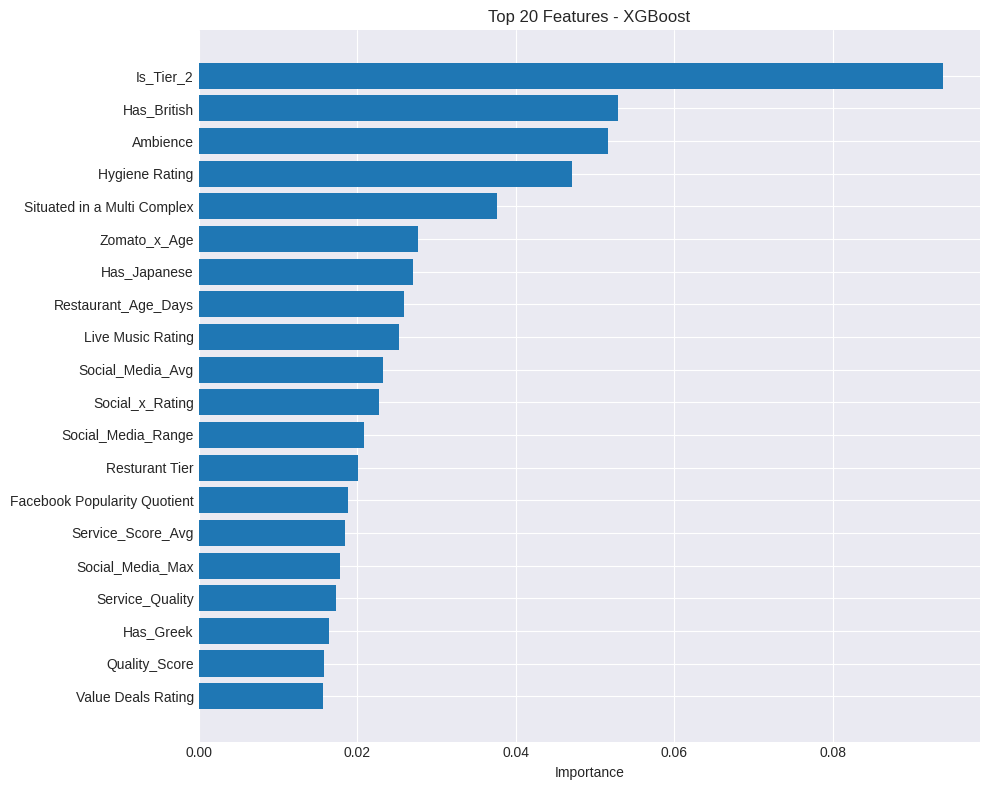

In [26]:
# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\n" + "="*70)
    print("TOP 20 MOST IMPORTANT FEATURES")
    print("="*70)
    display(feature_importance.head(20))

    # Visualize top features
    plt.figure(figsize=(10, 8))
    top_features = feature_importance.head(20)
    plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 20 Features - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print(f"\n{best_model_name} does not provide feature importance.")

## 7. Ensemble Prediction

Combining predictions from multiple models for potentially better results.

In [27]:
# Create ensemble of top 3 models
top_3_models = results_df.head(3)['Model'].tolist()

print("\n" + "="*70)
print("ENSEMBLE PREDICTION")
print("="*70)
print(f"Using top 3 models: {', '.join(top_3_models)}")

# Retrain top models on full training data
ensemble_models = []
for model_name in top_3_models:
    model = trained_models[model_name]
    # Retrain on full training data
    model.fit(X_train, y_train)
    ensemble_models.append(model)

# Make ensemble predictions on validation set
ensemble_pred_val = np.mean([model.predict(X_val) for model in ensemble_models], axis=0)
ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_pred_val))
ensemble_r2 = r2_score(y_val, ensemble_pred_val)

print(f"Ensemble Validation RMSE: {ensemble_rmse:,.0f}")
print(f"Ensemble Validation R²: {ensemble_r2:.4f}")
print(f"Best Single Model RMSE: {best_rmse:,.0f}")

if ensemble_rmse < best_rmse:
    print("Ensemble is better! Using ensemble for final predictions.")
    USE_ENSEMBLE = True
else:
    print("Single model is better! Using best model for final predictions.")
    USE_ENSEMBLE = False


ENSEMBLE PREDICTION
Using top 3 models: XGBoost, Random Forest, Lasso Regression
Ensemble Validation RMSE: 10,990,571
Ensemble Validation R²: 0.7343
Best Single Model RMSE: 19,226,783
Ensemble is better! Using ensemble for final predictions.


## 8. Final Predictions on Test Set

In [28]:
print("\n" + "="*70)
print("GENERATING FINAL PREDICTIONS")
print("="*70)

if USE_ENSEMBLE:
    # Ensemble prediction
    predictions = np.mean([model.predict(X_test) for model in ensemble_models], axis=0)
    print("Using ensemble of top 3 models")
else:
    # Single best model prediction
    predictions = best_model.predict(X_test)
    print(f"Using {best_model_name}")

# Create submission DataFrame
submission = pd.DataFrame({
    'Registration Number': test_ids,
    'Annual Turnover': predictions
})

# Ensure no negative predictions
submission['Annual Turnover'] = submission['Annual Turnover'].clip(lower=0)

print("\nPrediction Statistics:")
print(f"  Mean: {predictions.mean():,.0f}")
print(f"  Median: {np.median(predictions):,.0f}")
print(f"  Min: {predictions.min():,.0f}")
print(f"  Max: {predictions.max():,.0f}")
print(f"  Std: {predictions.std():,.0f}")

print("\nFirst 10 predictions:")
display(submission.head(10))


GENERATING FINAL PREDICTIONS
Using ensemble of top 3 models

Prediction Statistics:
  Mean: 31,636,619
  Median: 30,710,680
  Min: 17,139,059
  Max: 63,567,346
  Std: 7,904,025

First 10 predictions:


,Registration Number,Annual Turnover
0,20001,2.993440e+07
1,20002,3.845537e+07
2,20003,2.906640e+07
3,20004,4.755175e+07
4,20005,4.911746e+07
5,20006,3.878400e+07
6,20007,3.960514e+07
7,20008,5.222462e+07
8,20009,2.913823e+07
9,20010,2.374843e+07


In [29]:
# Save submission
submission.to_csv('/content/drive/MyDrive/restaurant_annual_turnover/Submission.csv', index=False)

print("\n" + "="*70)
print("SUBMISSION FILE CREATED: Submission.csv")
print("="*70)
print(f"Total predictions: {len(submission)}")
print(f"File ready for submission!")

# Verify submission format
print("\nSubmission file verification:")
print(f"  Shape: {submission.shape}")
print(f"  Columns: {list(submission.columns)}")
print(f"  Missing values: {submission.isnull().sum().sum()}")
print(f"  Duplicate IDs: {submission['Registration Number'].duplicated().sum()}")


SUBMISSION FILE CREATED: Submission.csv
Total predictions: 500
File ready for submission!

Submission file verification:
  Shape: (500, 2)
  Columns: ['Registration Number', 'Annual Turnover']
  Missing values: 0
  Duplicate IDs: 0
